In [246]:
# MLP
#https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [247]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [248]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [249]:
len(words)

32033

In [250]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X are input to the NN, Y are the labels for the each example in X
for w in words:
#for w in words[:5]:
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [252]:
# build the dataset - functional version
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# split the dataset Xtr - training, Xdev - validation, Xte - test
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [253]:
# input is 32 by 3 since we have 32 examples of context length 3
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [254]:
# starting to implement the embedded lookup table

C = torch.randn((27,2)) # we have 27 characters in our vocabulary, and we map them to 2D vectors

In [255]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [256]:
# implementing hidden layer
W1 = torch.randn((6, 100)) # 6 is the size of the embedding, 100 is the size of the hidden layer(kinda randomly chosen)
b1 = torch.randn((100)) # bias for the hidden layer

In [257]:
#emb @ W1 + b1   we cant exactly do this, since the dimensions dont match
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [258]:
# since the block size is 3, we can just concatenate the embeddings like this but what if the block size is 10?
# so unbind allows us to split the tensor into a list of tensors
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

# so thats also a way to do it, but we can also 'view' the whole new tensor as a 2D tensor like whole new storage

torch.Size([228146, 6])

In [259]:
emb.shape

torch.Size([228146, 3, 2])

In [260]:
#emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

In [261]:
# so creating the h like this allows us to do the matrix multiplication and addition of the bias
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 means infer the size from the other dimensions so this is 32 by 100
# this would work even if its not 32, but some other number of examples

# this is more efficient than the previous method because it just manipulate the view of the tensor, not the actual data

In [262]:
# creating the final layer
W2 = torch.randn((100, 27)) # 27 is the size of the vocabulary
b2 = torch.randn((27))

In [263]:
# output layer, logits are raw predictions which come out of the last layer of the nn
logits = h @ W2 + b2 # 32 by 27

In [264]:
logits.shape

torch.Size([228146, 27])

In [265]:
counts = logits.exp() # we take the exponential of the logits to get the probabilities

In [266]:
probs = counts / counts.sum(dim=1, keepdim=True) # we normalize the counts to get the probabilities

In [267]:
probs.shape

torch.Size([228146, 27])

In [268]:
# now via negative log likelihood loss we can calculate the loss
#loss = -probs[torch.arange(32), Y].log().mean() # we take the negative log of the probabilities of the correct characters
#loss # now thats the loss we want to minimize to get the nn to predict the next character correctly

In [269]:
# ---- Summary in respectable form ----
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [270]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator=g) # embedding layer

W1 = torch.randn((30, 200), generator=g) # hidden layer
b1 = torch.randn((200), generator=g) # bias for hidden layer

W2 = torch.randn((200, 27), generator=g) # output layer
b2 = torch.randn((27), generator=g) # bias for output layer

params = [C, W1, b1, W2, b2] # all the parameters of the model

In [271]:
sum(p.nelement() for p in params) # total number of parameters

11897

In [272]:
for p in params:
  p.requires_grad_() # we want to optimize these parameters

In [273]:
# finding the optimal learning rate
lre = torch.linspace(-3, 0, 1000) # creates 1000 candidate learning rate space from 10^-3 to 1
lrs = 10 ** lre # the actual learning rates

In [274]:
lri = [] # keeping the track of the loss for each learning rate
lossi = [] # keeping the track of the loss for each learning rate
stepi = []

In [275]:
# when we do the iteration on full dataset, it kinda slow so we can use mini-batches technique to speed up the training
# which is basically just taking a subset of the dataset and train on that
for i in range(30000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 examples in a mini-batch

    # forward pass
    emb = C[Xtr[ix]] # embedding lookup
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, Ytr[ix]) # cross-entropy loss

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # gradient descent which is just updating the parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.item())

print(f'Final loss: {loss.item()}')

Final loss: 2.5646557807922363


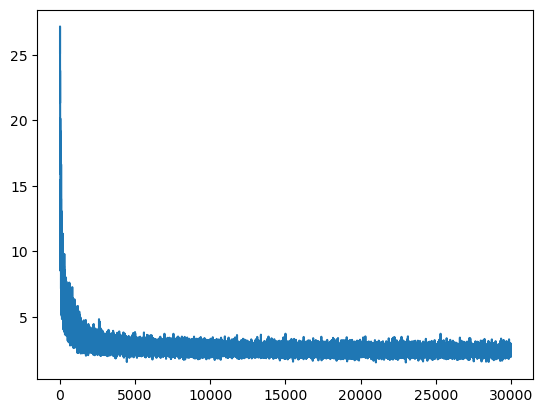

In [276]:
plt.plot(stepi, lossi)

In [277]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3722, grad_fn=<NllLossBackward0>)

In [278]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3945, grad_fn=<NllLossBackward0>)

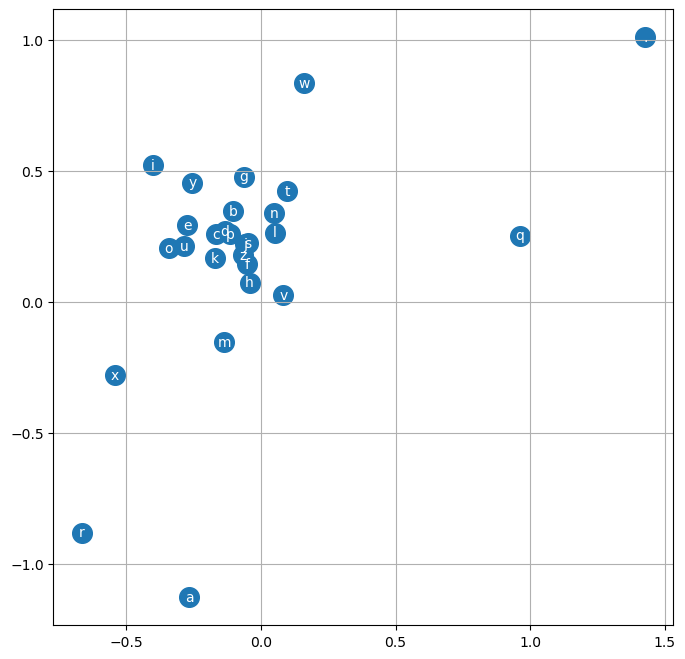

In [279]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i],  ha="center", va="center", color='white')
plt.grid('minor')

In [280]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [281]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chriah.
ame.
hevi.
kemro.
reh.
cahalaysie.
rahnen.
dresync.
raeni.
nermana.
chaiir.
elle.
gre.
lio.
din.
quinn.
shon.
raividhi.
wraelogijarisi.
fraen.
